In [1]:
import json
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_auc_score, silhouette_score
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer

RNG = np.random.default_rng(42)
EMBED_MODEL = SentenceTransformer("all-mpnet-base-v2") 

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd ../..
%pwd

/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/root/CoTFaithChecker'

In [3]:
def load_annotation_json(path: Path, label: str) -> pd.DataFrame:
    #Flatten the nested JSON into one row per (question_id, sentence_id, category)
    rows = []
    with open(path) as f:
        blob = json.load(f)

    for q in blob:
        qid = q["question_id"]
        for sent in q["annotations"]:
            sid = sent["sentence_id"]
            for cat, val in sent.items():
                if cat in {"sentence_id", "other_label"}:
                    continue
                if cat == "other":
                    continue  # skip generic "other" flag
                if isinstance(val, (int, float)) and val > 0:
                    rows.append(dict(question_id=qid,
                                     sentence_id=sid,
                                     category=cat,
                                     weight=val,
                                     condition=label))
    return pd.DataFrame(rows)

no_hint_path = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/filtered_60_verbalized_annotations_confidence_none.json")
with_hint_path = Path("c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/filtered_60_verbalized_annotations_confidence_sycophancy.json")

df_no_hint  = load_annotation_json(no_hint_path,  "no_hint")
df_with_hint = load_annotation_json(with_hint_path, "hint")

df  = pd.concat([df_no_hint, df_with_hint], ignore_index=True)
df.head()


,question_id,sentence_id,category,weight,condition
0,13,1,problem_restating,0.9,no_hint
1,13,2,problem_restating,0.9,no_hint
2,13,3,problem_restating,0.9,no_hint
3,13,4,problem_restating,0.8,no_hint
4,13,4,answer_reporting,0.9,no_hint


Chi² =60.39, p =3.06e-09, dof =10


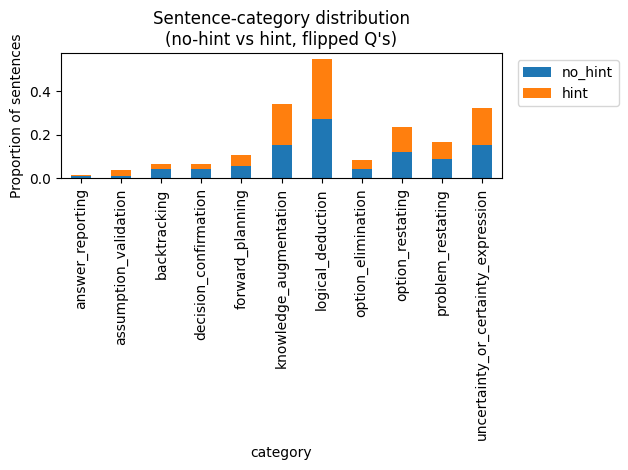

In [4]:
cats = sorted(df['category'].unique())
pivot = (df.groupby(['condition', 'category'])
           .size()
           .unstack(fill_value=0)
           .loc[['no_hint', 'hint']])

# χ 2 test (rows = condition, cols = category)
chi2, p, dof, _ = chi2_contingency(pivot.values)
print(f"Chi² ={chi2:.2f}, p ={p:.3g}, dof ={dof}")

# Stacked barplot of proportions
props = pivot.div(pivot.sum(axis=1), axis=0)
fig, ax = plt.subplots()
props.T.plot(kind='bar', ax=ax, stacked=True)
ax.set_title("Sentence-category distribution\n(no-hint vs hint, flipped Q's)")
ax.set_ylabel("Proportion of sentences")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()


condition
hint       0.186136
no_hint    0.154837
dtype: float64


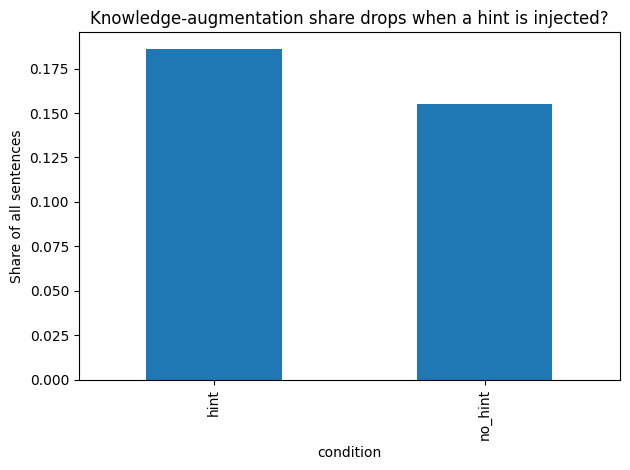

In [5]:
ka_counts = (df[df['category'] == 'knowledge_augmentation']
             .groupby('condition')
             .size())
total_counts = df.groupby('condition').size()

share = ka_counts / total_counts
print(share)

fig, ax = plt.subplots()
share.plot(kind='bar', ax=ax)
ax.set_ylabel("Share of all sentences")
ax.set_title("Knowledge-augmentation share drops when a hint is injected?")
plt.tight_layout()


Batches: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]


Silhouette across 11 categories: 1.000


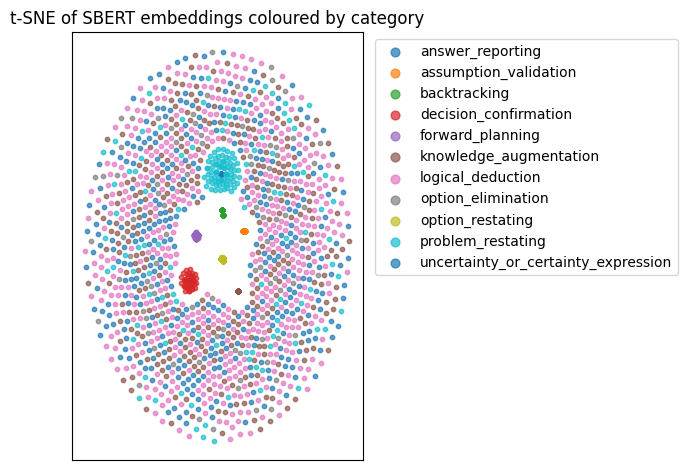

In [6]:
SAMPLE_SIZE = 2_000
sample_df = df.sample(SAMPLE_SIZE, random_state=42)

sent_texts = sample_df['category']
embeddings = EMBED_MODEL.encode(sent_texts.tolist(), batch_size=64, show_progress_bar=True)

# Dim-red (TSNE)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='random')
coords = tsne.fit_transform(embeddings)

viz_df = sample_df.reset_index(drop=True).assign(x=coords[:,0], y=coords[:,1])

fig, ax = plt.subplots()
for cat in cats:
    sub = viz_df[viz_df['category'] == cat]
    ax.scatter(sub['x'], sub['y'], label=cat, s=10, alpha=0.7)
ax.set_title("t-SNE of SBERT embeddings coloured by category")
ax.set_xticks([]); ax.set_yticks([])
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left', markerscale=2)
plt.tight_layout()

# Silhouette (higher = better separation)
sil = silhouette_score(embeddings, sample_df['category'])
print(f"Silhouette across {len(cats)} categories: {sil:.3f}")
